In [3]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

Mounted at /content/gdrive


## **Regression**

* 일반적으로 딥러닝을 생각하면 여러가지 분야로 나눠 분류함 (컴퓨터 비젼, 자연어 처리…)
 * 이런 직관적 분류법은 더 깊고 의미있는 내용을 놓칠 수 있음
   * 사진 (indep variable) 에서 텍스트를 (dep variable)
   * 텍스트, 테이블 데이터, 사진에서 (indep variables) 제품을 (dep variable) 추천
* 이런 자신만의 유니크한 애플리케이션과 문제를 이해하고 적용하면 datablock API를 최대로 활용 가능함
 * Image Regression (사진 input-> float 숫자 output)
   * Key Point Model
     * 사진안에서의 특정 위치를 표현하는 값 (인물의 얼굴의 중심 위치
     * Output 값이 두개임 (얼굴 중심의 row 와 column 값)

## **Assembling the Data**
*   Biwi Kinect Head Pose Dataset 을 사용한 head center location estimation



In [4]:
# 우선 데이터가 저장된 URL을 불러온다
path = untar_data(URLs.BIWI_HEAD_POSE)

In [6]:
# path에 저장되어 있는 경로들을 리스트해본다 (sorted 함수는 리스팅을 ascending 순서로 보여줌)
path.ls().sorted()

(#50) [Path('/root/.fastai/data/biwi_head_pose/01'),Path('/root/.fastai/data/biwi_head_pose/01.obj'),Path('/root/.fastai/data/biwi_head_pose/02'),Path('/root/.fastai/data/biwi_head_pose/02.obj'),Path('/root/.fastai/data/biwi_head_pose/03'),Path('/root/.fastai/data/biwi_head_pose/03.obj'),Path('/root/.fastai/data/biwi_head_pose/04'),Path('/root/.fastai/data/biwi_head_pose/04.obj'),Path('/root/.fastai/data/biwi_head_pose/05'),Path('/root/.fastai/data/biwi_head_pose/05.obj')...]

In [7]:
# 01~24까지의 디렉토리가 있음 (각각 다른 사람들의 사진)
# 아래는 첫번째 디렉토리를 확인
(path/'01').ls().sorted()

(#1000) [Path('/root/.fastai/data/biwi_head_pose/01/depth.cal'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00003_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00003_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00004_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00004_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00005_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00005_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00006_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00006_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00007_pose.txt')...]

In [8]:
# 각각 디렉토리마다 파일은 사진과 (_rgb.jpg) 관련된 머리 포즈임 (_pose.txt)
# get_image_files 함수를 통해 리커시브하게 파일들을 불러올 수 있음
# 아래는 img2pose 라는 함수를 만들어 rgb.jpg 와 pose.txt를 따옴
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')

print(img_files[0])
print(img2pose(img_files[0]))

/root/.fastai/data/biwi_head_pose/10/frame_00188_rgb.jpg
/root/.fastai/data/biwi_head_pose/10/frame_00188_pose.txt


(480, 640)


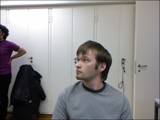

In [9]:
# 불러온 이미지를 체크해볼 수 있음
im = PILImage.create(img_files[0])
print(im.shape)
im.to_thumb(160)

In [10]:
# 기본적으로 Biwi 데이터셋에 제공된 정보를 이용해서 인물의 머리 위치 정보를 추출한다
# 만든 함수를 사용하여 X, Y 좌표를 알 수 있음
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

get_ctr(img_files[0])

tensor([344.8080, 254.0485])

In [11]:
# 이 아이템을 DataBlock의 get_y 의 argument 로 넣으면 학습이 가능함
# 학습의 train, valid 데이터를 나누는데 random splitter을 사용하면 안됨 (학습한 사람들의 데이터가 새로운 사람의 (training data에 없던) 사진에서도 잘 되기위해)
# datablock 의 block argument 의 두번째 block은 pointblock 을 사용하여야 좌표값을 라벨로 사용함을 알 수 있음
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)]
)

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

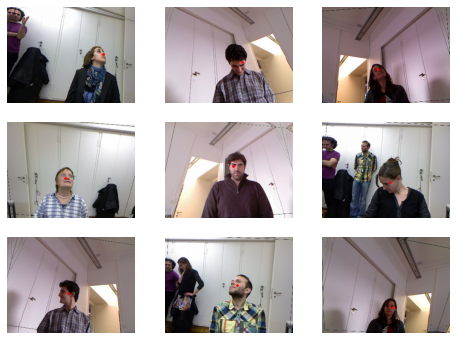

In [12]:
# 만들어진 DataBlock의 한 batch를 확인할 수 있음 (dataloader's' 인 이유는 train 과 valid 가 있어서임)
# 비슷한 방법으로 한 batch가 실제로 어떤 tensor 값을 가지고 있는지 볼 수 있음
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))
xb, yb = dls.one_batch()
xb.shape, yb.shape

## **Training a Model**

In [13]:
# 비슷한 방법으로 cnn_learner 을 이용해서 모델을 학습할 수 있다
# y_range 를 이용해서 output 의 범위를 지정할 수 있음
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


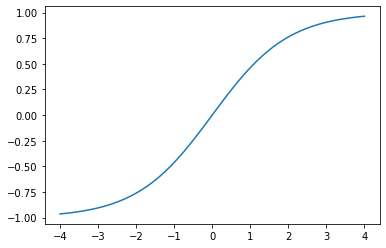

In [14]:
# Fastai 에서는 y_range를 sigmoid_range 로 정의한 함수를 사용함
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo
plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4, max=4)

In [15]:
# cnn_learner 의 argument 에 loss function을 지정해주지 않았기에 Fastai 의 기본 loss 함수를 사용함
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=7.585775847473997e-07)

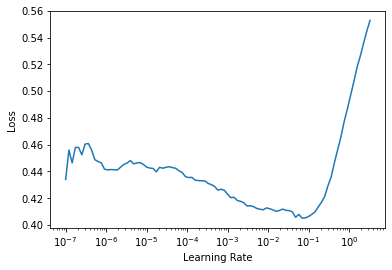

In [ ]:
# 앞 단원에서 배운 learning rate finder 을 사용할 수있음
learn.lr_find()

In [16]:
# 1e-1 이 최저짐이기 때문에, 한 order 낮은 1e-2를 learning rate 로 사용
lr = 1e-2
learn.fine_tune(1, lr)

epoch,train_loss,valid_loss,time
0,0.050050,0.009751,02:22


epoch,train_loss,valid_loss,time
0,0.003452,0.000567,02:32


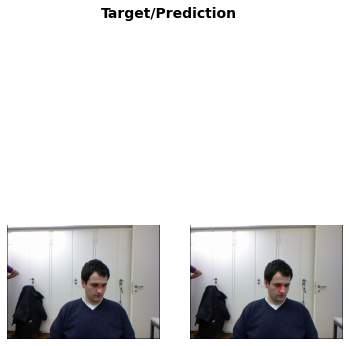

In [24]:
#학습된 모델의 퍼포먼스를 확인할 수 있음 (좌측이 true, 우측이 pred)
# 유동적인 API와 전이학습을 이용해서 좋은 퍼포먼스를 얻을 수 있음 (pretrained model이 새로운 application에도 잘 사용될 수 있음)
learn.show_results(ds_idx=1, max_n=2, figsize=(6,8))